# Imports iniciais

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import svm, tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Import do dataset

In [ ]:
pd.set_option('display.max_rows', 300)

file_path = "../datasets/oficial-limpo.csv"
LABEL_COLUMN = 'IDPergu'

dataframe = pd.read_csv(file_path, index_col=False)
to_be_altered = dataframe
columns = dataframe[[LABEL_COLUMN, 'IDVolunt', 'IDTrial', 'FrameID', 'palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z']]
unique_voluntairs = dataframe['IDVolunt'].unique()

target_label = pd.get_dummies(dataframe[LABEL_COLUMN])

#Normalização
# Removo os dados que não vão ser usados para depois normalizar
df_remaining = to_be_altered.drop(columns=[LABEL_COLUMN, 'IDVolunt', 'IDTrial', 'FrameID', 'palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z'])
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_remaining), columns=df_remaining.columns)

# Volto a juntar os dados já normalizados com os que removi anteriormente para poder identificar as coisas por ID de voluntario
df_normalized_with_removed = pd.concat([df_normalized, dataframe[[LABEL_COLUMN, 'IDVolunt', 'IDTrial', 'FrameID', 'palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z']]], axis=1)

# Save dos dados da normalização do dataset para serem usados na inferência em tempo real
import json
scaling_params = {
    "mean": list(scaler.mean_),
    "scale": list(scaler.scale_)
}

with open("scaling_params.json", "w") as params_file:
    json.dump(scaling_params, params_file)

   IDPergu  IDVolunt  IDTrial  FrameID  palm.stable-pos.x  palm.stable-pos.y   
0        0         3        0   234523                0.0                0.0  \
1        0         3        0   234525                0.0                0.0   
2        0         3        0   234526                0.0                0.0   
3        0         3        0   234527                0.0                0.0   
4        0         3        0   234528                0.0                0.0   

   palm.stable-pos.z  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
[ 3  6  4  5  7  8  9  2 11 12 13 14 15  1 18 19 20 21 22 23 24]
   IDVolunt  IDPergu  IDTrial  FrameID  visible_time  grab_angle   
0         3        0        0   234523      16556061    2.631817  \
1         3        0        0   234525      16572768    2.630713   
2         3        0        0   234526      16586628    2.631420   
3         3        0        0   234527      

# Verificação do balanceamento do dataset

In [ ]:
class_counts = dataframe[LABEL_COLUMN].value_counts()

class_labels = class_counts.index
class_counts = class_counts.values
class_labels = ['click', 'move', 'rotate', 'zoom in', 'zoom out', 'mouse']

# Step 3: Define a list of colors for each class
# You can customize the colors as per your preference
colors = ['blue', 'purple', 'green', 'orange', 'brown', 'red']

# Step 2: Visualize class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color=colors)
#plt.title('Class Distribution of Features Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

# Folds de validação

In [3]:
val_folds = [
    [5, 13, 18],
    [3, 21, 20],
    [14, 12, 13],
    [4, 22, 7],
    [24, 9, 5],
    [23, 19, 15],
    [4, 12, 22],
    [6, 13, 24],
    [9, 18, 20]
    ]

# Dados de teste

In [3]:
# Test data readied
test_set = df_normalized_with_removed.loc[dataframe["IDVolunt"].isin([10,8,11,16])]
print(unique_voluntairs)
unique_voluntairs = unique_voluntairs[unique_voluntairs != 10]
unique_voluntairs = unique_voluntairs[unique_voluntairs != 8]
unique_voluntairs = unique_voluntairs[unique_voluntairs != 11]
unique_voluntairs = unique_voluntairs[unique_voluntairs != 16]
print(unique_voluntairs)
test_labels = pd.get_dummies(test_set[LABEL_COLUMN])
test_labels_one_column = test_set[LABEL_COLUMN]
test_features_reduced = test_set.drop(columns=['IDVolunt','IDPergu','IDTrial','FrameID','visible_time','grab_angle','pinch_strength','left/right','palm.dir.x','palm.dir.y','palm.dir.z','palm.normal.x','palm.normal.y','palm.normal.z','palm.orienta.x','palm.orienta.y','palm.orienta.z','palm.orienta.w','palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z','palm.velocity.x','palm.velocity.y','palm.velocity.z','palm.width','thumb_extend','index_extend','middle_extended','ring_extended','pinky_extend','arm.rot.x','arm.rot.y','arm.rot.z','arm.rot.w','arm.width','arm.prev.x','arm.prev.y','arm.prev.z','arm.next.x','arm.next.y','arm.next.z','thumb.metacarpal.rot.x','thumb.metacarpal.rot.y','thumb.metacarpal.rot.z','thumb.metacarpal.rot.w','thumb.metacarpal.width','thumb.metacarpal.prev.x','thumb.metacarpal.prev.y','thumb.metacarpal.prev.z','thumb.metacarpal.next.x','thumb.metacarpal.next.y','thumb.metacarpal.next.z','thumb.proximal.rot.x','thumb.proximal.rot.y','thumb.proximal.rot.z','thumb.proximal.rot.w','thumb.proximal.width','thumb.proximal.prev.x','thumb.proximal.prev.y','thumb.proximal.prev.z','thumb.proximal.next.x','thumb.proximal.next.y','thumb.proximal.next.z','thumb.intermediate.rot.x','thumb.intermediate.rot.y','thumb.intermediate.rot.z','thumb.intermediate.rot.w','thumb.intermediate.width','thumb.intermediate.prev.x','thumb.intermediate.prev.y','thumb.intermediate.prev.z','thumb.intermediate.next.x','thumb.intermediate.next.y','thumb.intermediate.next.z','thumb.distal.rot.x','thumb.distal.rot.y','thumb.distal.rot.z','thumb.distal.rot.w','thumb.distal.width','thumb.distal.prev.x','thumb.distal.prev.y','thumb.distal.prev.z','index.metacarpal.rot.x','index.metacarpal.rot.y','index.metacarpal.rot.z','index.metacarpal.rot.w','index.metacarpal.width','index.metacarpal.prev.x','index.metacarpal.prev.y','index.metacarpal.prev.z','index.metacarpal.next.x','index.metacarpal.next.y','index.metacarpal.next.z','index.proximal.rot.x','index.proximal.rot.y','index.proximal.rot.z','index.proximal.rot.w','index.proximal.width','index.proximal.prev.x','index.proximal.prev.y','index.proximal.prev.z','index.proximal.next.x','index.proximal.next.y','index.proximal.next.z','index.intermediate.rot.x','index.intermediate.rot.y','index.intermediate.rot.z','index.intermediate.rot.w','index.intermediate.width','index.intermediate.prev.x','index.intermediate.prev.y','index.intermediate.prev.z','index.intermediate.next.x','index.intermediate.next.y','index.intermediate.next.z','index.distal.rot.x','index.distal.rot.y','index.distal.rot.z','index.distal.rot.w','index.distal.width','index.distal.prev.x','index.distal.prev.y','index.distal.prev.z','middle.metacarpal.rot.x','middle.metacarpal.rot.y','middle.metacarpal.rot.z','middle.metacarpal.rot.w','middle.metacarpal.width','middle.metacarpal.prev.x','middle.metacarpal.prev.y','middle.metacarpal.prev.z','middle.metacarpal.next.x','middle.metacarpal.next.y','middle.metacarpal.next.z','middle.proximal.rot.x','middle.proximal.rot.y','middle.proximal.rot.z','middle.proximal.rot.w','middle.proximal.width','middle.proximal.prev.x','middle.proximal.prev.y','middle.proximal.prev.z','middle.proximal.next.x','middle.proximal.next.y','middle.proximal.next.z','middle.intermediate.rot.x','middle.intermediate.rot.y','middle.intermediate.rot.z','middle.intermediate.rot.w','middle.intermediate.width','middle.intermediate.prev.x','middle.intermediate.prev.y','middle.intermediate.prev.z','middle.intermediate.next.x','middle.intermediate.next.y','middle.intermediate.next.z','middle.distal.rot.x','middle.distal.rot.y','middle.distal.rot.z','middle.distal.rot.w','middle.distal.width','middle.distal.prev.x','middle.distal.prev.y','middle.distal.prev.z','ring.metacarpal.rot.x','ring.metacarpal.rot.y','ring.metacarpal.rot.z','ring.metacarpal.rot.w','ring.metacarpal.width','ring.metacarpal.prev.x','ring.metacarpal.prev.y','ring.metacarpal.prev.z','ring.metacarpal.next.x','ring.metacarpal.next.y','ring.metacarpal.next.z','ring.proximal.rot.x','ring.proximal.rot.y','ring.proximal.rot.z','ring.proximal.rot.w','ring.proximal.width','ring.proximal.prev.x','ring.proximal.prev.y','ring.proximal.prev.z','ring.proximal.next.x','ring.proximal.next.y','ring.proximal.next.z','ring.intermediate.rot.x','ring.intermediate.rot.y','ring.intermediate.rot.z','ring.intermediate.rot.w','ring.intermediate.width','ring.intermediate.prev.x','ring.intermediate.prev.y','ring.intermediate.prev.z','ring.intermediate.next.x','ring.intermediate.next.y','ring.intermediate.next.z','ring.distal.rot.x','ring.distal.rot.y','ring.distal.rot.z','ring.distal.rot.w','ring.distal.width','ring.distal.prev.x','ring.distal.prev.y','ring.distal.prev.z','ring.distal.next.x','ring.distal.next.y','ring.distal.next.z','pinky.metacarpal.rot.x','pinky.metacarpal.rot.y','pinky.metacarpal.rot.z','pinky.metacarpal.rot.w','pinky.metacarpal.width','pinky.metacarpal.prev.x','pinky.metacarpal.prev.y','pinky.metacarpal.prev.z','pinky.metacarpal.next.x','pinky.metacarpal.next.y','pinky.metacarpal.next.z','pinky.proximal.rot.x','pinky.proximal.rot.y','pinky.proximal.rot.z','pinky.proximal.rot.w','pinky.proximal.width','pinky.proximal.prev.x','pinky.proximal.prev.y','pinky.proximal.prev.z','pinky.proximal.next.x','pinky.proximal.next.y','pinky.proximal.next.z','pinky.intermediate.rot.x','pinky.intermediate.rot.y','pinky.intermediate.rot.z','pinky.intermediate.rot.w','pinky.intermediate.width','pinky.intermediate.prev.x','pinky.intermediate.prev.y','pinky.intermediate.prev.z','pinky.intermediate.next.x','pinky.intermediate.next.y','pinky.intermediate.next.z','pinky.distal.rot.x','pinky.distal.rot.y','pinky.distal.rot.z','pinky.distal.rot.w','pinky.distal.width','pinky.distal.prev.x','pinky.distal.prev.y','pinky.distal.prev.z','pinky.distal.next.x','pinky.distal.next.y','pinky.distal.next.z'])
test_features = test_set.drop(columns=[LABEL_COLUMN, 'IDVolunt', 'IDTrial', 'FrameID', 'palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z'])

# Remoção dos dados de teste do dataset que vai ser usado nas folds
fold_set = df_normalized_with_removed.drop(df_normalized_with_removed[(df_normalized_with_removed["IDVolunt"] == 10)].index)
fold_set = fold_set.drop(fold_set[(fold_set["IDVolunt"] == 8)].index)
fold_set = fold_set.drop(fold_set[(fold_set["IDVolunt"] == 11)].index)
fold_set = fold_set.drop(fold_set[(fold_set["IDVolunt"] == 16)].index)
print(fold_set["IDVolunt"].unique())

[ 3  6  4  5  7  8  9  2 11 12 13 14 15  1 18 19 20 21 22 23 24]
[ 3  6  4  5  7  9  2 12 13 14 15  1 18 19 20 21 22 23 24]
[ 3  6  4  5  7  9  2 12 13 14 15  1 18 19 20 21 22 23 24]


# Dados de validação

In [3]:
def get_val_dataset(val_indexes):
    val_set = fold_set.loc[fold_set["IDVolunt"].isin(val_indexes)]
    val_label = pd.get_dummies(val_set[LABEL_COLUMN])
    val_features = val_set.drop(columns=[LABEL_COLUMN, 'IDVolunt', 'IDTrial', 'FrameID', 'palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z'])
    return val_features, val_label

# Dados de treino

In [4]:
def get_train_dataset(val_indexes):
    for i in val_indexes:
        training_set = fold_set.drop(fold_set[(fold_set["IDVolunt"] == i)].index)
    
    train_label = pd.get_dummies(training_set[LABEL_COLUMN])
    train_label = training_set[LABEL_COLUMN]
    train_features = training_set.drop(columns=[LABEL_COLUMN, 'IDVolunt', 'IDTrial', 'FrameID', 'palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z'])
    return train_features, train_label

# Model with linear activation

In [4]:
def model_without_activation():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(200))
    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.Dense(60))
    model.add(tf.keras.layers.Dense(30))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    return model

def prepare_callbacks(directory):
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=directory,
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

## Loop de treino

In [8]:
history_array_without = []
result_array_without = []
current_fold = 0

for fold in val_folds:
    # Buscar o dataset de validação
    val_features, val_labels = get_val_dataset(fold)
    
    # Buscar o dataset de treino
    train_features, train_labels = get_train_dataset(fold)
    
    # Instancio um modelo novo
    model = model_without_activation()

    # Preparo os callback do novo modelo
    callbacks = prepare_callbacks(f"model-without-act/{current_fold}/test.ckpt")

    # Treino o modelo e guardo a historia num array
    history = model.fit(train_features, train_labels, batch_size=25, epochs=50, validation_data=(val_features, val_labels), callbacks=callbacks)
    history_array_without.append(history)

    result = model.evaluate(test_features, test_labels)
    result_array_without.append(result)

    current_fold += 1

Epoch 1/50
10359/10368 [============================>.] - ETA: 0s - loss: 0.0673 - accuracy: 0.9792
Epoch 1: val_accuracy improved from -inf to 0.94199, saving model to model-without-act/0\test.ckpt
10368/10368 [==============================] - 51s 5ms/step - loss: 0.0673 - accuracy: 0.9792 - val_loss: 0.7619 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 2/50
10364/10368 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9933
Epoch 2: val_accuracy did not improve from 0.94199
10368/10368 [==============================] - 51s 5ms/step - loss: 0.0222 - accuracy: 0.9933 - val_loss: 1.2455 - val_accuracy: 0.9371 - lr: 1.0000e-04
Epoch 3/50
10358/10368 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9952
Epoch 3: val_accuracy did not improve from 0.94199
10368/10368 [==============================] - 51s 5ms/step - loss: 0.0161 - accuracy: 0.9952 - val_loss: 1.5512 - val_accuracy: 0.9390 - lr: 1.0000e-04
Epoch 4/50
10360/10368 [================

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## Resultado dos dados de teste para os 9 modelos

900/900 [==============================] - 2s 3ms/step


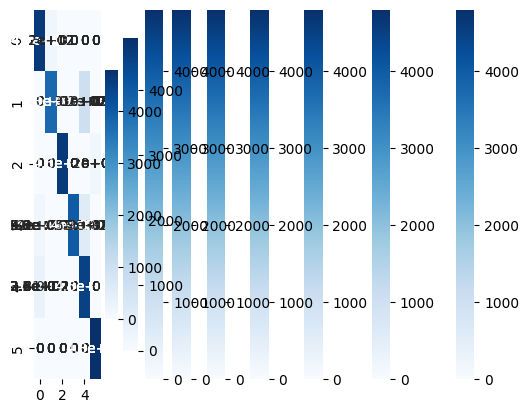

In [11]:
for i in range(9):
    model = model_without_activation()

    model.load_weights(f"C:\\modelTraining\\featureBased\\model-without-act\\{i}\\test.ckpt")

    model.evaluate(test_features, test_labels)
    predictions = model.predict(test_features)
    predicted_labels = np.argmax(predictions, axis=1)
    test_labels_adapted = np.argmax(test_labels, axis=1)

    cm = tf.math.confusion_matrix(test_labels_adapted, predicted_labels)

    sns.heatmap(cm, annot=True, cmap='Blues')

## Resultado e matriz de confusão para um modelo específico

900/900 [==============================] - 3s 4ms/step


Text(50.722222222222214, 0.5, 'True labels')

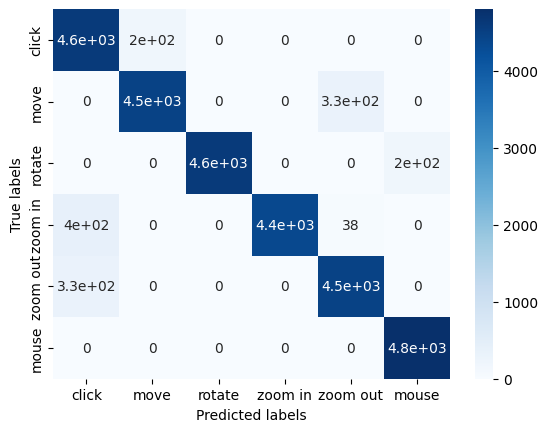

In [6]:
model = model_without_activation()

model.load_weights(f"C:\\modelTraining\\featureBased\\model-without-act\\0\\test.ckpt")

#model.evaluate(test_features, test_labels)
predictions = model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)
test_labels_adapted = np.argmax(test_labels, axis=1)

cm = tf.math.confusion_matrix(test_labels_adapted, predicted_labels)

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['click', 'move', 'rotate', 'zoom in', 'zoom out', 'mouse'], yticklabels= ['click', 'move', 'rotate', 'zoom in', 'zoom out', 'mouse'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

## Save do modelo

In [22]:
model = model_without_activation()

model.load_weights(f"C:\\modelTraining\\featureBased\\model-without-act\\0\\test.ckpt")

model.evaluate(test_features, test_labels)
model.save("protobuf-models/model-without-act-fold0")

900/900 [==============================] - 5s 4ms/step - loss: 0.2722 - accuracy: 0.9480
INFO:tensorflow:Assets written to: protobuf-models/model-without-act-fold0\assets


# Model with ReLU

In [7]:
def model_with_relu():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(200, activation='relu'))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(60, activation='relu'))
    model.add(tf.keras.layers.Dense(30, activation='relu'))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    return model

def prepare_callbacks(directory):
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=directory,
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

## Loop de treino

In [11]:
history_array_without = []
result_array_without = []
current_fold = 0

for fold in val_folds:
    # Buscar o dataset de validação
    val_features, val_labels = get_val_dataset(fold)
    
    # Buscar o dataset de treino
    train_features, train_labels = get_train_dataset(fold)
    
    # Instancio um modelo novo
    model = model_with_relu()

    # Preparo os callback do novo modelo
    callbacks = prepare_callbacks(f"model-with-act/{current_fold}/test.ckpt")

    # Treino o modelo e guardo a historia num array
    history = model.fit(train_features, train_labels, batch_size=25, epochs=50, validation_data=(val_features, val_labels), callbacks=callbacks)
    history_array_without.append(history)

    result = model.evaluate(test_features, test_labels)
    result_array_without.append(result)

    current_fold += 1

Epoch 1/50
10368/10368 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9873
Epoch 1: val_accuracy improved from -inf to 0.95222, saving model to model-with-act/0\test.ckpt
10368/10368 [==============================] - 56s 5ms/step - loss: 0.0478 - accuracy: 0.9873 - val_loss: 0.4378 - val_accuracy: 0.9522 - lr: 1.0000e-04
Epoch 2/50
10358/10368 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997
Epoch 2: val_accuracy improved from 0.95222 to 0.95637, saving model to model-with-act/0\test.ckpt
10368/10368 [==============================] - 56s 5ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.5233 - val_accuracy: 0.9564 - lr: 1.0000e-04
Epoch 3/50
10367/10368 [============================>.] - ETA: 0s - loss: 8.4140e-04 - accuracy: 0.9998
Epoch 3: val_accuracy improved from 0.95637 to 0.96086, saving model to model-with-act/0\test.ckpt
10368/10368 [==============================] - 57s 6ms/step - loss: 8.4133e-04 - accuracy: 0.999

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## Resultado dos dados de teste para os 9 modelos

In [16]:
for i in range(9):
    model = model_with_relu()

    model.load_weights(f"C:\\modelTraining\\featureBased\\model-with-act\\{i}\\test.ckpt")

    model.evaluate(test_features, test_labels)
    predictions = model.predict(test_features)
    predicted_labels = np.argmax(predictions, axis=1)
    test_labels_adapted = np.argmax(test_labels, axis=1)

    cm = tf.math.confusion_matrix(test_labels_adapted, predicted_labels)

900/900 [==============================] - 2s 3ms/step


## Resultados e matriz de confusão para um modelo específico

900/900 [==============================] - 2s 2ms/step


Text(50.722222222222214, 0.5, 'True labels')

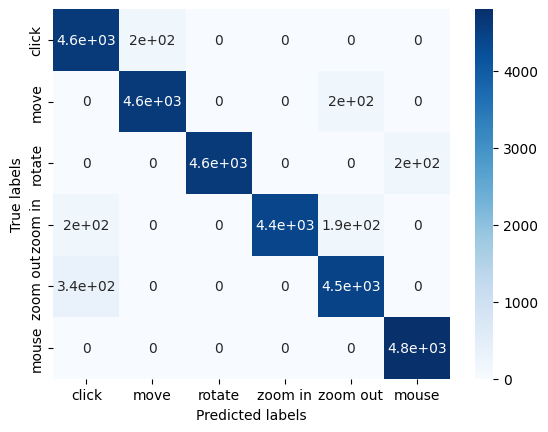

In [8]:
model = model_with_relu()

model.load_weights(f"C:\\modelTraining\\featureBased\\model-with-act\\6\\test.ckpt")

model.evaluate(test_features, test_labels)
predictions = model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)
test_labels_adapted = np.argmax(test_labels, axis=1)

cm = tf.math.confusion_matrix(test_labels_adapted, predicted_labels)

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['click', 'move', 'rotate', 'zoom in', 'zoom out', 'mouse'], yticklabels= ['click', 'move', 'rotate', 'zoom in', 'zoom out', 'mouse'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

## Save do modelo

In [ ]:
model = model_with_relu()

model.load_weights(f"C:\\modelTraining\\featureBased\\model-with-act\\0\\test.ckpt")

model.evaluate(test_features, test_labels)
model.save("protobuf-models/model-with-act-fold0")

# SVM

        grab_strength  pinch_dis  palm.position.x  palm.position.y   
0            -0.67739   0.089747        -0.293812        -0.617846  \
1            -0.67739   0.086959        -0.291993        -0.618941   
2            -0.67739   0.086541        -0.291358        -0.619307   
3            -0.67739   0.086618        -0.290749        -0.619698   
4            -0.67739   0.086359        -0.290030        -0.620066   
...               ...        ...              ...              ...   
302395       -0.67739   1.106280        -2.859031         2.791702   
302396       -0.67739   1.224303        -2.854891         2.823472   
302397       -0.67739   1.146073        -2.864166         2.827652   
302398       -0.67739   1.103679        -2.870128         2.849018   
302399       -0.67739   1.047451        -2.869414         2.862948   

        palm.position.z  thumb.distal.next.x  thumb.distal.next.y   
0              0.148215             0.225017            -0.819107  \
1              0.1518

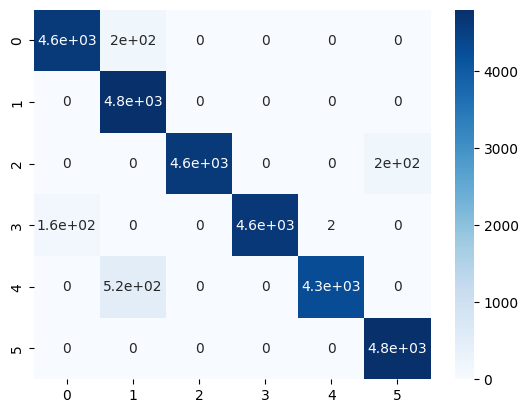

In [17]:
# Buscar o dataset de treino
train_label = fold_set[LABEL_COLUMN]
train_features = fold_set.drop(columns=['IDVolunt','IDPergu','IDTrial','FrameID','visible_time','grab_angle','pinch_strength','left/right','palm.dir.x','palm.dir.y','palm.dir.z','palm.normal.x','palm.normal.y','palm.normal.z','palm.orienta.x','palm.orienta.y','palm.orienta.z','palm.orienta.w','palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z','palm.velocity.x','palm.velocity.y','palm.velocity.z','palm.width','thumb_extend','index_extend','middle_extended','ring_extended','pinky_extend','arm.rot.x','arm.rot.y','arm.rot.z','arm.rot.w','arm.width','arm.prev.x','arm.prev.y','arm.prev.z','arm.next.x','arm.next.y','arm.next.z','thumb.metacarpal.rot.x','thumb.metacarpal.rot.y','thumb.metacarpal.rot.z','thumb.metacarpal.rot.w','thumb.metacarpal.width','thumb.metacarpal.prev.x','thumb.metacarpal.prev.y','thumb.metacarpal.prev.z','thumb.metacarpal.next.x','thumb.metacarpal.next.y','thumb.metacarpal.next.z','thumb.proximal.rot.x','thumb.proximal.rot.y','thumb.proximal.rot.z','thumb.proximal.rot.w','thumb.proximal.width','thumb.proximal.prev.x','thumb.proximal.prev.y','thumb.proximal.prev.z','thumb.proximal.next.x','thumb.proximal.next.y','thumb.proximal.next.z','thumb.intermediate.rot.x','thumb.intermediate.rot.y','thumb.intermediate.rot.z','thumb.intermediate.rot.w','thumb.intermediate.width','thumb.intermediate.prev.x','thumb.intermediate.prev.y','thumb.intermediate.prev.z','thumb.intermediate.next.x','thumb.intermediate.next.y','thumb.intermediate.next.z','thumb.distal.rot.x','thumb.distal.rot.y','thumb.distal.rot.z','thumb.distal.rot.w','thumb.distal.width','thumb.distal.prev.x','thumb.distal.prev.y','thumb.distal.prev.z','index.metacarpal.rot.x','index.metacarpal.rot.y','index.metacarpal.rot.z','index.metacarpal.rot.w','index.metacarpal.width','index.metacarpal.prev.x','index.metacarpal.prev.y','index.metacarpal.prev.z','index.metacarpal.next.x','index.metacarpal.next.y','index.metacarpal.next.z','index.proximal.rot.x','index.proximal.rot.y','index.proximal.rot.z','index.proximal.rot.w','index.proximal.width','index.proximal.prev.x','index.proximal.prev.y','index.proximal.prev.z','index.proximal.next.x','index.proximal.next.y','index.proximal.next.z','index.intermediate.rot.x','index.intermediate.rot.y','index.intermediate.rot.z','index.intermediate.rot.w','index.intermediate.width','index.intermediate.prev.x','index.intermediate.prev.y','index.intermediate.prev.z','index.intermediate.next.x','index.intermediate.next.y','index.intermediate.next.z','index.distal.rot.x','index.distal.rot.y','index.distal.rot.z','index.distal.rot.w','index.distal.width','index.distal.prev.x','index.distal.prev.y','index.distal.prev.z','middle.metacarpal.rot.x','middle.metacarpal.rot.y','middle.metacarpal.rot.z','middle.metacarpal.rot.w','middle.metacarpal.width','middle.metacarpal.prev.x','middle.metacarpal.prev.y','middle.metacarpal.prev.z','middle.metacarpal.next.x','middle.metacarpal.next.y','middle.metacarpal.next.z','middle.proximal.rot.x','middle.proximal.rot.y','middle.proximal.rot.z','middle.proximal.rot.w','middle.proximal.width','middle.proximal.prev.x','middle.proximal.prev.y','middle.proximal.prev.z','middle.proximal.next.x','middle.proximal.next.y','middle.proximal.next.z','middle.intermediate.rot.x','middle.intermediate.rot.y','middle.intermediate.rot.z','middle.intermediate.rot.w','middle.intermediate.width','middle.intermediate.prev.x','middle.intermediate.prev.y','middle.intermediate.prev.z','middle.intermediate.next.x','middle.intermediate.next.y','middle.intermediate.next.z','middle.distal.rot.x','middle.distal.rot.y','middle.distal.rot.z','middle.distal.rot.w','middle.distal.width','middle.distal.prev.x','middle.distal.prev.y','middle.distal.prev.z','ring.metacarpal.rot.x','ring.metacarpal.rot.y','ring.metacarpal.rot.z','ring.metacarpal.rot.w','ring.metacarpal.width','ring.metacarpal.prev.x','ring.metacarpal.prev.y','ring.metacarpal.prev.z','ring.metacarpal.next.x','ring.metacarpal.next.y','ring.metacarpal.next.z','ring.proximal.rot.x','ring.proximal.rot.y','ring.proximal.rot.z','ring.proximal.rot.w','ring.proximal.width','ring.proximal.prev.x','ring.proximal.prev.y','ring.proximal.prev.z','ring.proximal.next.x','ring.proximal.next.y','ring.proximal.next.z','ring.intermediate.rot.x','ring.intermediate.rot.y','ring.intermediate.rot.z','ring.intermediate.rot.w','ring.intermediate.width','ring.intermediate.prev.x','ring.intermediate.prev.y','ring.intermediate.prev.z','ring.intermediate.next.x','ring.intermediate.next.y','ring.intermediate.next.z','ring.distal.rot.x','ring.distal.rot.y','ring.distal.rot.z','ring.distal.rot.w','ring.distal.width','ring.distal.prev.x','ring.distal.prev.y','ring.distal.prev.z','ring.distal.next.x','ring.distal.next.y','ring.distal.next.z','pinky.metacarpal.rot.x','pinky.metacarpal.rot.y','pinky.metacarpal.rot.z','pinky.metacarpal.rot.w','pinky.metacarpal.width','pinky.metacarpal.prev.x','pinky.metacarpal.prev.y','pinky.metacarpal.prev.z','pinky.metacarpal.next.x','pinky.metacarpal.next.y','pinky.metacarpal.next.z','pinky.proximal.rot.x','pinky.proximal.rot.y','pinky.proximal.rot.z','pinky.proximal.rot.w','pinky.proximal.width','pinky.proximal.prev.x','pinky.proximal.prev.y','pinky.proximal.prev.z','pinky.proximal.next.x','pinky.proximal.next.y','pinky.proximal.next.z','pinky.intermediate.rot.x','pinky.intermediate.rot.y','pinky.intermediate.rot.z','pinky.intermediate.rot.w','pinky.intermediate.width','pinky.intermediate.prev.x','pinky.intermediate.prev.y','pinky.intermediate.prev.z','pinky.intermediate.next.x','pinky.intermediate.next.y','pinky.intermediate.next.z','pinky.distal.rot.x','pinky.distal.rot.y','pinky.distal.rot.z','pinky.distal.rot.w','pinky.distal.width','pinky.distal.prev.x','pinky.distal.prev.y','pinky.distal.prev.z','pinky.distal.next.x','pinky.distal.next.y','pinky.distal.next.z'])
    
C_range = [0.5, 1, 10]
gamma_range = [1, 5, 10]

parameters = {
    "C": C_range,
    "kernel": ["linear", "rbf"],
    "degree": gamma_range,
}

# Instancio um modelo novo
model = svm.SVC(decision_function_shape='ovo', random_state=10)
grid = GridSearchCV(model, param_grid=parameters, verbose=1, n_jobs=-1, cv=2)

# Treino o modelo e guardo a historia
history = grid.fit(train_features, train_label)
print("The best parameters are %s with a score of %f"
      % (grid.best_params_, grid.best_score_))

result = grid.predict(test_features)
accur = accuracy_score(test_labels_one_column, result)
print(accur)
cm = confusion_matrix(test_labels_one_column, result)

sns.heatmap(cm, annot=True, cmap='Blues')

## Treino e save do melhor modelo

In [9]:
import joblib
# Buscar o dataset de treino
train_label = fold_set[LABEL_COLUMN]
train_features = fold_set.drop(columns=['IDVolunt','IDPergu','IDTrial','FrameID','visible_time','grab_angle','pinch_strength','left/right','palm.dir.x','palm.dir.y','palm.dir.z','palm.normal.x','palm.normal.y','palm.normal.z','palm.orienta.x','palm.orienta.y','palm.orienta.z','palm.orienta.w','palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z','palm.velocity.x','palm.velocity.y','palm.velocity.z','palm.width','thumb_extend','index_extend','middle_extended','ring_extended','pinky_extend','arm.rot.x','arm.rot.y','arm.rot.z','arm.rot.w','arm.width','arm.prev.x','arm.prev.y','arm.prev.z','arm.next.x','arm.next.y','arm.next.z','thumb.metacarpal.rot.x','thumb.metacarpal.rot.y','thumb.metacarpal.rot.z','thumb.metacarpal.rot.w','thumb.metacarpal.width','thumb.metacarpal.prev.x','thumb.metacarpal.prev.y','thumb.metacarpal.prev.z','thumb.metacarpal.next.x','thumb.metacarpal.next.y','thumb.metacarpal.next.z','thumb.proximal.rot.x','thumb.proximal.rot.y','thumb.proximal.rot.z','thumb.proximal.rot.w','thumb.proximal.width','thumb.proximal.prev.x','thumb.proximal.prev.y','thumb.proximal.prev.z','thumb.proximal.next.x','thumb.proximal.next.y','thumb.proximal.next.z','thumb.intermediate.rot.x','thumb.intermediate.rot.y','thumb.intermediate.rot.z','thumb.intermediate.rot.w','thumb.intermediate.width','thumb.intermediate.prev.x','thumb.intermediate.prev.y','thumb.intermediate.prev.z','thumb.intermediate.next.x','thumb.intermediate.next.y','thumb.intermediate.next.z','thumb.distal.rot.x','thumb.distal.rot.y','thumb.distal.rot.z','thumb.distal.rot.w','thumb.distal.width','thumb.distal.prev.x','thumb.distal.prev.y','thumb.distal.prev.z','index.metacarpal.rot.x','index.metacarpal.rot.y','index.metacarpal.rot.z','index.metacarpal.rot.w','index.metacarpal.width','index.metacarpal.prev.x','index.metacarpal.prev.y','index.metacarpal.prev.z','index.metacarpal.next.x','index.metacarpal.next.y','index.metacarpal.next.z','index.proximal.rot.x','index.proximal.rot.y','index.proximal.rot.z','index.proximal.rot.w','index.proximal.width','index.proximal.prev.x','index.proximal.prev.y','index.proximal.prev.z','index.proximal.next.x','index.proximal.next.y','index.proximal.next.z','index.intermediate.rot.x','index.intermediate.rot.y','index.intermediate.rot.z','index.intermediate.rot.w','index.intermediate.width','index.intermediate.prev.x','index.intermediate.prev.y','index.intermediate.prev.z','index.intermediate.next.x','index.intermediate.next.y','index.intermediate.next.z','index.distal.rot.x','index.distal.rot.y','index.distal.rot.z','index.distal.rot.w','index.distal.width','index.distal.prev.x','index.distal.prev.y','index.distal.prev.z','middle.metacarpal.rot.x','middle.metacarpal.rot.y','middle.metacarpal.rot.z','middle.metacarpal.rot.w','middle.metacarpal.width','middle.metacarpal.prev.x','middle.metacarpal.prev.y','middle.metacarpal.prev.z','middle.metacarpal.next.x','middle.metacarpal.next.y','middle.metacarpal.next.z','middle.proximal.rot.x','middle.proximal.rot.y','middle.proximal.rot.z','middle.proximal.rot.w','middle.proximal.width','middle.proximal.prev.x','middle.proximal.prev.y','middle.proximal.prev.z','middle.proximal.next.x','middle.proximal.next.y','middle.proximal.next.z','middle.intermediate.rot.x','middle.intermediate.rot.y','middle.intermediate.rot.z','middle.intermediate.rot.w','middle.intermediate.width','middle.intermediate.prev.x','middle.intermediate.prev.y','middle.intermediate.prev.z','middle.intermediate.next.x','middle.intermediate.next.y','middle.intermediate.next.z','middle.distal.rot.x','middle.distal.rot.y','middle.distal.rot.z','middle.distal.rot.w','middle.distal.width','middle.distal.prev.x','middle.distal.prev.y','middle.distal.prev.z','ring.metacarpal.rot.x','ring.metacarpal.rot.y','ring.metacarpal.rot.z','ring.metacarpal.rot.w','ring.metacarpal.width','ring.metacarpal.prev.x','ring.metacarpal.prev.y','ring.metacarpal.prev.z','ring.metacarpal.next.x','ring.metacarpal.next.y','ring.metacarpal.next.z','ring.proximal.rot.x','ring.proximal.rot.y','ring.proximal.rot.z','ring.proximal.rot.w','ring.proximal.width','ring.proximal.prev.x','ring.proximal.prev.y','ring.proximal.prev.z','ring.proximal.next.x','ring.proximal.next.y','ring.proximal.next.z','ring.intermediate.rot.x','ring.intermediate.rot.y','ring.intermediate.rot.z','ring.intermediate.rot.w','ring.intermediate.width','ring.intermediate.prev.x','ring.intermediate.prev.y','ring.intermediate.prev.z','ring.intermediate.next.x','ring.intermediate.next.y','ring.intermediate.next.z','ring.distal.rot.x','ring.distal.rot.y','ring.distal.rot.z','ring.distal.rot.w','ring.distal.width','ring.distal.prev.x','ring.distal.prev.y','ring.distal.prev.z','ring.distal.next.x','ring.distal.next.y','ring.distal.next.z','pinky.metacarpal.rot.x','pinky.metacarpal.rot.y','pinky.metacarpal.rot.z','pinky.metacarpal.rot.w','pinky.metacarpal.width','pinky.metacarpal.prev.x','pinky.metacarpal.prev.y','pinky.metacarpal.prev.z','pinky.metacarpal.next.x','pinky.metacarpal.next.y','pinky.metacarpal.next.z','pinky.proximal.rot.x','pinky.proximal.rot.y','pinky.proximal.rot.z','pinky.proximal.rot.w','pinky.proximal.width','pinky.proximal.prev.x','pinky.proximal.prev.y','pinky.proximal.prev.z','pinky.proximal.next.x','pinky.proximal.next.y','pinky.proximal.next.z','pinky.intermediate.rot.x','pinky.intermediate.rot.y','pinky.intermediate.rot.z','pinky.intermediate.rot.w','pinky.intermediate.width','pinky.intermediate.prev.x','pinky.intermediate.prev.y','pinky.intermediate.prev.z','pinky.intermediate.next.x','pinky.intermediate.next.y','pinky.intermediate.next.z','pinky.distal.rot.x','pinky.distal.rot.y','pinky.distal.rot.z','pinky.distal.rot.w','pinky.distal.width','pinky.distal.prev.x','pinky.distal.prev.y','pinky.distal.prev.z','pinky.distal.next.x','pinky.distal.next.y','pinky.distal.next.z'])

# Instancio um modelo novo
model = svm.SVC(decision_function_shape='ovo', random_state=10, C=0.5, degree=1, kernel='linear')
# Treino o modelo e guardo a historia num array
history = model.fit(train_features, train_label)

joblib.dump(model, 'svm.sav')

['svm.sav']

## Treino do melhor modelo

[3 3 3 ... 5 5 5]
0.9625347222222222


Text(50.722222222222214, 0.5, 'True labels')

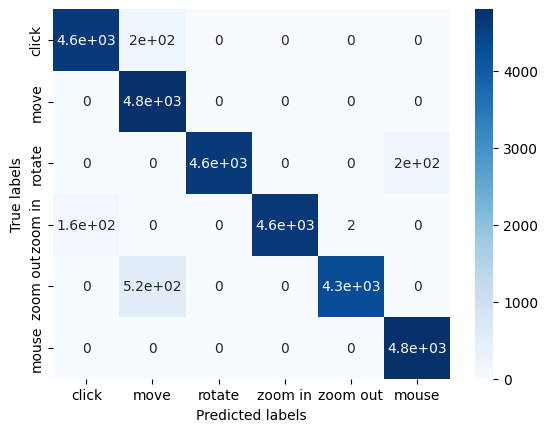

In [11]:
train_label = fold_set[LABEL_COLUMN]
train_features = fold_set.drop(columns=['IDVolunt','IDPergu','IDTrial','FrameID','visible_time','grab_angle','pinch_strength','left/right','palm.dir.x','palm.dir.y','palm.dir.z','palm.normal.x','palm.normal.y','palm.normal.z','palm.orienta.x','palm.orienta.y','palm.orienta.z','palm.orienta.w','palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z','palm.velocity.x','palm.velocity.y','palm.velocity.z','palm.width','thumb_extend','index_extend','middle_extended','ring_extended','pinky_extend','arm.rot.x','arm.rot.y','arm.rot.z','arm.rot.w','arm.width','arm.prev.x','arm.prev.y','arm.prev.z','arm.next.x','arm.next.y','arm.next.z','thumb.metacarpal.rot.x','thumb.metacarpal.rot.y','thumb.metacarpal.rot.z','thumb.metacarpal.rot.w','thumb.metacarpal.width','thumb.metacarpal.prev.x','thumb.metacarpal.prev.y','thumb.metacarpal.prev.z','thumb.metacarpal.next.x','thumb.metacarpal.next.y','thumb.metacarpal.next.z','thumb.proximal.rot.x','thumb.proximal.rot.y','thumb.proximal.rot.z','thumb.proximal.rot.w','thumb.proximal.width','thumb.proximal.prev.x','thumb.proximal.prev.y','thumb.proximal.prev.z','thumb.proximal.next.x','thumb.proximal.next.y','thumb.proximal.next.z','thumb.intermediate.rot.x','thumb.intermediate.rot.y','thumb.intermediate.rot.z','thumb.intermediate.rot.w','thumb.intermediate.width','thumb.intermediate.prev.x','thumb.intermediate.prev.y','thumb.intermediate.prev.z','thumb.intermediate.next.x','thumb.intermediate.next.y','thumb.intermediate.next.z','thumb.distal.rot.x','thumb.distal.rot.y','thumb.distal.rot.z','thumb.distal.rot.w','thumb.distal.width','thumb.distal.prev.x','thumb.distal.prev.y','thumb.distal.prev.z','index.metacarpal.rot.x','index.metacarpal.rot.y','index.metacarpal.rot.z','index.metacarpal.rot.w','index.metacarpal.width','index.metacarpal.prev.x','index.metacarpal.prev.y','index.metacarpal.prev.z','index.metacarpal.next.x','index.metacarpal.next.y','index.metacarpal.next.z','index.proximal.rot.x','index.proximal.rot.y','index.proximal.rot.z','index.proximal.rot.w','index.proximal.width','index.proximal.prev.x','index.proximal.prev.y','index.proximal.prev.z','index.proximal.next.x','index.proximal.next.y','index.proximal.next.z','index.intermediate.rot.x','index.intermediate.rot.y','index.intermediate.rot.z','index.intermediate.rot.w','index.intermediate.width','index.intermediate.prev.x','index.intermediate.prev.y','index.intermediate.prev.z','index.intermediate.next.x','index.intermediate.next.y','index.intermediate.next.z','index.distal.rot.x','index.distal.rot.y','index.distal.rot.z','index.distal.rot.w','index.distal.width','index.distal.prev.x','index.distal.prev.y','index.distal.prev.z','middle.metacarpal.rot.x','middle.metacarpal.rot.y','middle.metacarpal.rot.z','middle.metacarpal.rot.w','middle.metacarpal.width','middle.metacarpal.prev.x','middle.metacarpal.prev.y','middle.metacarpal.prev.z','middle.metacarpal.next.x','middle.metacarpal.next.y','middle.metacarpal.next.z','middle.proximal.rot.x','middle.proximal.rot.y','middle.proximal.rot.z','middle.proximal.rot.w','middle.proximal.width','middle.proximal.prev.x','middle.proximal.prev.y','middle.proximal.prev.z','middle.proximal.next.x','middle.proximal.next.y','middle.proximal.next.z','middle.intermediate.rot.x','middle.intermediate.rot.y','middle.intermediate.rot.z','middle.intermediate.rot.w','middle.intermediate.width','middle.intermediate.prev.x','middle.intermediate.prev.y','middle.intermediate.prev.z','middle.intermediate.next.x','middle.intermediate.next.y','middle.intermediate.next.z','middle.distal.rot.x','middle.distal.rot.y','middle.distal.rot.z','middle.distal.rot.w','middle.distal.width','middle.distal.prev.x','middle.distal.prev.y','middle.distal.prev.z','ring.metacarpal.rot.x','ring.metacarpal.rot.y','ring.metacarpal.rot.z','ring.metacarpal.rot.w','ring.metacarpal.width','ring.metacarpal.prev.x','ring.metacarpal.prev.y','ring.metacarpal.prev.z','ring.metacarpal.next.x','ring.metacarpal.next.y','ring.metacarpal.next.z','ring.proximal.rot.x','ring.proximal.rot.y','ring.proximal.rot.z','ring.proximal.rot.w','ring.proximal.width','ring.proximal.prev.x','ring.proximal.prev.y','ring.proximal.prev.z','ring.proximal.next.x','ring.proximal.next.y','ring.proximal.next.z','ring.intermediate.rot.x','ring.intermediate.rot.y','ring.intermediate.rot.z','ring.intermediate.rot.w','ring.intermediate.width','ring.intermediate.prev.x','ring.intermediate.prev.y','ring.intermediate.prev.z','ring.intermediate.next.x','ring.intermediate.next.y','ring.intermediate.next.z','ring.distal.rot.x','ring.distal.rot.y','ring.distal.rot.z','ring.distal.rot.w','ring.distal.width','ring.distal.prev.x','ring.distal.prev.y','ring.distal.prev.z','ring.distal.next.x','ring.distal.next.y','ring.distal.next.z','pinky.metacarpal.rot.x','pinky.metacarpal.rot.y','pinky.metacarpal.rot.z','pinky.metacarpal.rot.w','pinky.metacarpal.width','pinky.metacarpal.prev.x','pinky.metacarpal.prev.y','pinky.metacarpal.prev.z','pinky.metacarpal.next.x','pinky.metacarpal.next.y','pinky.metacarpal.next.z','pinky.proximal.rot.x','pinky.proximal.rot.y','pinky.proximal.rot.z','pinky.proximal.rot.w','pinky.proximal.width','pinky.proximal.prev.x','pinky.proximal.prev.y','pinky.proximal.prev.z','pinky.proximal.next.x','pinky.proximal.next.y','pinky.proximal.next.z','pinky.intermediate.rot.x','pinky.intermediate.rot.y','pinky.intermediate.rot.z','pinky.intermediate.rot.w','pinky.intermediate.width','pinky.intermediate.prev.x','pinky.intermediate.prev.y','pinky.intermediate.prev.z','pinky.intermediate.next.x','pinky.intermediate.next.y','pinky.intermediate.next.z','pinky.distal.rot.x','pinky.distal.rot.y','pinky.distal.rot.z','pinky.distal.rot.w','pinky.distal.width','pinky.distal.prev.x','pinky.distal.prev.y','pinky.distal.prev.z','pinky.distal.next.x','pinky.distal.next.y','pinky.distal.next.z'])
model = svm.SVC(decision_function_shape='ovo', random_state=10, C=0.5, degree=1, kernel='linear')
history = model.fit(train_features, train_label)
result = model.predict(test_features_reduced)
print(result)
accur = accuracy_score(test_labels_one_column, result)
print(accur)
cm = confusion_matrix(test_labels_one_column, result)

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['click', 'move', 'rotate', 'zoom in', 'zoom out', 'mouse'], yticklabels= ['click', 'move', 'rotate', 'zoom in', 'zoom out', 'mouse'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Binary Tree

Fitting 2 folds for each of 54 candidates, totalling 108 fits
The best parameters are {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 2} with a score of 0.735172
0.7784722222222222


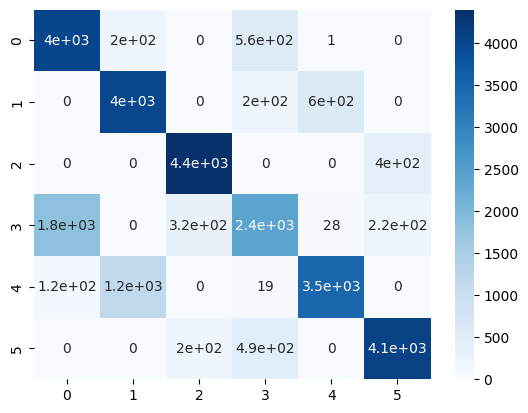

In [15]:
# Buscar o dataset de treino
train_label = fold_set[LABEL_COLUMN]
train_features = fold_set.drop(columns=['IDVolunt','IDPergu','IDTrial','FrameID','visible_time','grab_angle','pinch_strength','left/right','palm.dir.x','palm.dir.y','palm.dir.z','palm.normal.x','palm.normal.y','palm.normal.z','palm.orienta.x','palm.orienta.y','palm.orienta.z','palm.orienta.w','palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z','palm.velocity.x','palm.velocity.y','palm.velocity.z','palm.width','thumb_extend','index_extend','middle_extended','ring_extended','pinky_extend','arm.rot.x','arm.rot.y','arm.rot.z','arm.rot.w','arm.width','arm.prev.x','arm.prev.y','arm.prev.z','arm.next.x','arm.next.y','arm.next.z','thumb.metacarpal.rot.x','thumb.metacarpal.rot.y','thumb.metacarpal.rot.z','thumb.metacarpal.rot.w','thumb.metacarpal.width','thumb.metacarpal.prev.x','thumb.metacarpal.prev.y','thumb.metacarpal.prev.z','thumb.metacarpal.next.x','thumb.metacarpal.next.y','thumb.metacarpal.next.z','thumb.proximal.rot.x','thumb.proximal.rot.y','thumb.proximal.rot.z','thumb.proximal.rot.w','thumb.proximal.width','thumb.proximal.prev.x','thumb.proximal.prev.y','thumb.proximal.prev.z','thumb.proximal.next.x','thumb.proximal.next.y','thumb.proximal.next.z','thumb.intermediate.rot.x','thumb.intermediate.rot.y','thumb.intermediate.rot.z','thumb.intermediate.rot.w','thumb.intermediate.width','thumb.intermediate.prev.x','thumb.intermediate.prev.y','thumb.intermediate.prev.z','thumb.intermediate.next.x','thumb.intermediate.next.y','thumb.intermediate.next.z','thumb.distal.rot.x','thumb.distal.rot.y','thumb.distal.rot.z','thumb.distal.rot.w','thumb.distal.width','thumb.distal.prev.x','thumb.distal.prev.y','thumb.distal.prev.z','index.metacarpal.rot.x','index.metacarpal.rot.y','index.metacarpal.rot.z','index.metacarpal.rot.w','index.metacarpal.width','index.metacarpal.prev.x','index.metacarpal.prev.y','index.metacarpal.prev.z','index.metacarpal.next.x','index.metacarpal.next.y','index.metacarpal.next.z','index.proximal.rot.x','index.proximal.rot.y','index.proximal.rot.z','index.proximal.rot.w','index.proximal.width','index.proximal.prev.x','index.proximal.prev.y','index.proximal.prev.z','index.proximal.next.x','index.proximal.next.y','index.proximal.next.z','index.intermediate.rot.x','index.intermediate.rot.y','index.intermediate.rot.z','index.intermediate.rot.w','index.intermediate.width','index.intermediate.prev.x','index.intermediate.prev.y','index.intermediate.prev.z','index.intermediate.next.x','index.intermediate.next.y','index.intermediate.next.z','index.distal.rot.x','index.distal.rot.y','index.distal.rot.z','index.distal.rot.w','index.distal.width','index.distal.prev.x','index.distal.prev.y','index.distal.prev.z','middle.metacarpal.rot.x','middle.metacarpal.rot.y','middle.metacarpal.rot.z','middle.metacarpal.rot.w','middle.metacarpal.width','middle.metacarpal.prev.x','middle.metacarpal.prev.y','middle.metacarpal.prev.z','middle.metacarpal.next.x','middle.metacarpal.next.y','middle.metacarpal.next.z','middle.proximal.rot.x','middle.proximal.rot.y','middle.proximal.rot.z','middle.proximal.rot.w','middle.proximal.width','middle.proximal.prev.x','middle.proximal.prev.y','middle.proximal.prev.z','middle.proximal.next.x','middle.proximal.next.y','middle.proximal.next.z','middle.intermediate.rot.x','middle.intermediate.rot.y','middle.intermediate.rot.z','middle.intermediate.rot.w','middle.intermediate.width','middle.intermediate.prev.x','middle.intermediate.prev.y','middle.intermediate.prev.z','middle.intermediate.next.x','middle.intermediate.next.y','middle.intermediate.next.z','middle.distal.rot.x','middle.distal.rot.y','middle.distal.rot.z','middle.distal.rot.w','middle.distal.width','middle.distal.prev.x','middle.distal.prev.y','middle.distal.prev.z','ring.metacarpal.rot.x','ring.metacarpal.rot.y','ring.metacarpal.rot.z','ring.metacarpal.rot.w','ring.metacarpal.width','ring.metacarpal.prev.x','ring.metacarpal.prev.y','ring.metacarpal.prev.z','ring.metacarpal.next.x','ring.metacarpal.next.y','ring.metacarpal.next.z','ring.proximal.rot.x','ring.proximal.rot.y','ring.proximal.rot.z','ring.proximal.rot.w','ring.proximal.width','ring.proximal.prev.x','ring.proximal.prev.y','ring.proximal.prev.z','ring.proximal.next.x','ring.proximal.next.y','ring.proximal.next.z','ring.intermediate.rot.x','ring.intermediate.rot.y','ring.intermediate.rot.z','ring.intermediate.rot.w','ring.intermediate.width','ring.intermediate.prev.x','ring.intermediate.prev.y','ring.intermediate.prev.z','ring.intermediate.next.x','ring.intermediate.next.y','ring.intermediate.next.z','ring.distal.rot.x','ring.distal.rot.y','ring.distal.rot.z','ring.distal.rot.w','ring.distal.width','ring.distal.prev.x','ring.distal.prev.y','ring.distal.prev.z','ring.distal.next.x','ring.distal.next.y','ring.distal.next.z','pinky.metacarpal.rot.x','pinky.metacarpal.rot.y','pinky.metacarpal.rot.z','pinky.metacarpal.rot.w','pinky.metacarpal.width','pinky.metacarpal.prev.x','pinky.metacarpal.prev.y','pinky.metacarpal.prev.z','pinky.metacarpal.next.x','pinky.metacarpal.next.y','pinky.metacarpal.next.z','pinky.proximal.rot.x','pinky.proximal.rot.y','pinky.proximal.rot.z','pinky.proximal.rot.w','pinky.proximal.width','pinky.proximal.prev.x','pinky.proximal.prev.y','pinky.proximal.prev.z','pinky.proximal.next.x','pinky.proximal.next.y','pinky.proximal.next.z','pinky.intermediate.rot.x','pinky.intermediate.rot.y','pinky.intermediate.rot.z','pinky.intermediate.rot.w','pinky.intermediate.width','pinky.intermediate.prev.x','pinky.intermediate.prev.y','pinky.intermediate.prev.z','pinky.intermediate.next.x','pinky.intermediate.next.y','pinky.intermediate.next.z','pinky.distal.rot.x','pinky.distal.rot.y','pinky.distal.rot.z','pinky.distal.rot.w','pinky.distal.width','pinky.distal.prev.x','pinky.distal.prev.y','pinky.distal.prev.z','pinky.distal.next.x','pinky.distal.next.y','pinky.distal.next.z'])

parameters = {
    "criterion": ['gini', 'entropy'],
    "max_depth": [10,15,20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 8]
}

# Instancio um modelo novo
model = tree.DecisionTreeClassifier(random_state=10)
grid = GridSearchCV(model, param_grid=parameters, verbose=1, n_jobs=-1, cv=2)

# Treino o modelo e guardo a historia num array
history = grid.fit(train_features, train_label)
print("The best parameters are %s with a score of %f"
      % (grid.best_params_, grid.best_score_))

result = grid.predict(test_features)
accur = accuracy_score(test_labels_one_column, result)
print(accur)
cm = confusion_matrix(test_labels_one_column, result)

sns.heatmap(cm, annot=True, cmap='Blues')

## Save do melhor modelo

In [7]:
import joblib
# Buscar o dataset de treino
train_label = fold_set[LABEL_COLUMN]
train_features = fold_set.drop(columns=['IDVolunt','IDPergu','IDTrial','FrameID','visible_time','grab_angle','pinch_strength','left/right','palm.dir.x','palm.dir.y','palm.dir.z','palm.normal.x','palm.normal.y','palm.normal.z','palm.orienta.x','palm.orienta.y','palm.orienta.z','palm.orienta.w','palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z','palm.velocity.x','palm.velocity.y','palm.velocity.z','palm.width','thumb_extend','index_extend','middle_extended','ring_extended','pinky_extend','arm.rot.x','arm.rot.y','arm.rot.z','arm.rot.w','arm.width','arm.prev.x','arm.prev.y','arm.prev.z','arm.next.x','arm.next.y','arm.next.z','thumb.metacarpal.rot.x','thumb.metacarpal.rot.y','thumb.metacarpal.rot.z','thumb.metacarpal.rot.w','thumb.metacarpal.width','thumb.metacarpal.prev.x','thumb.metacarpal.prev.y','thumb.metacarpal.prev.z','thumb.metacarpal.next.x','thumb.metacarpal.next.y','thumb.metacarpal.next.z','thumb.proximal.rot.x','thumb.proximal.rot.y','thumb.proximal.rot.z','thumb.proximal.rot.w','thumb.proximal.width','thumb.proximal.prev.x','thumb.proximal.prev.y','thumb.proximal.prev.z','thumb.proximal.next.x','thumb.proximal.next.y','thumb.proximal.next.z','thumb.intermediate.rot.x','thumb.intermediate.rot.y','thumb.intermediate.rot.z','thumb.intermediate.rot.w','thumb.intermediate.width','thumb.intermediate.prev.x','thumb.intermediate.prev.y','thumb.intermediate.prev.z','thumb.intermediate.next.x','thumb.intermediate.next.y','thumb.intermediate.next.z','thumb.distal.rot.x','thumb.distal.rot.y','thumb.distal.rot.z','thumb.distal.rot.w','thumb.distal.width','thumb.distal.prev.x','thumb.distal.prev.y','thumb.distal.prev.z','index.metacarpal.rot.x','index.metacarpal.rot.y','index.metacarpal.rot.z','index.metacarpal.rot.w','index.metacarpal.width','index.metacarpal.prev.x','index.metacarpal.prev.y','index.metacarpal.prev.z','index.metacarpal.next.x','index.metacarpal.next.y','index.metacarpal.next.z','index.proximal.rot.x','index.proximal.rot.y','index.proximal.rot.z','index.proximal.rot.w','index.proximal.width','index.proximal.prev.x','index.proximal.prev.y','index.proximal.prev.z','index.proximal.next.x','index.proximal.next.y','index.proximal.next.z','index.intermediate.rot.x','index.intermediate.rot.y','index.intermediate.rot.z','index.intermediate.rot.w','index.intermediate.width','index.intermediate.prev.x','index.intermediate.prev.y','index.intermediate.prev.z','index.intermediate.next.x','index.intermediate.next.y','index.intermediate.next.z','index.distal.rot.x','index.distal.rot.y','index.distal.rot.z','index.distal.rot.w','index.distal.width','index.distal.prev.x','index.distal.prev.y','index.distal.prev.z','middle.metacarpal.rot.x','middle.metacarpal.rot.y','middle.metacarpal.rot.z','middle.metacarpal.rot.w','middle.metacarpal.width','middle.metacarpal.prev.x','middle.metacarpal.prev.y','middle.metacarpal.prev.z','middle.metacarpal.next.x','middle.metacarpal.next.y','middle.metacarpal.next.z','middle.proximal.rot.x','middle.proximal.rot.y','middle.proximal.rot.z','middle.proximal.rot.w','middle.proximal.width','middle.proximal.prev.x','middle.proximal.prev.y','middle.proximal.prev.z','middle.proximal.next.x','middle.proximal.next.y','middle.proximal.next.z','middle.intermediate.rot.x','middle.intermediate.rot.y','middle.intermediate.rot.z','middle.intermediate.rot.w','middle.intermediate.width','middle.intermediate.prev.x','middle.intermediate.prev.y','middle.intermediate.prev.z','middle.intermediate.next.x','middle.intermediate.next.y','middle.intermediate.next.z','middle.distal.rot.x','middle.distal.rot.y','middle.distal.rot.z','middle.distal.rot.w','middle.distal.width','middle.distal.prev.x','middle.distal.prev.y','middle.distal.prev.z','ring.metacarpal.rot.x','ring.metacarpal.rot.y','ring.metacarpal.rot.z','ring.metacarpal.rot.w','ring.metacarpal.width','ring.metacarpal.prev.x','ring.metacarpal.prev.y','ring.metacarpal.prev.z','ring.metacarpal.next.x','ring.metacarpal.next.y','ring.metacarpal.next.z','ring.proximal.rot.x','ring.proximal.rot.y','ring.proximal.rot.z','ring.proximal.rot.w','ring.proximal.width','ring.proximal.prev.x','ring.proximal.prev.y','ring.proximal.prev.z','ring.proximal.next.x','ring.proximal.next.y','ring.proximal.next.z','ring.intermediate.rot.x','ring.intermediate.rot.y','ring.intermediate.rot.z','ring.intermediate.rot.w','ring.intermediate.width','ring.intermediate.prev.x','ring.intermediate.prev.y','ring.intermediate.prev.z','ring.intermediate.next.x','ring.intermediate.next.y','ring.intermediate.next.z','ring.distal.rot.x','ring.distal.rot.y','ring.distal.rot.z','ring.distal.rot.w','ring.distal.width','ring.distal.prev.x','ring.distal.prev.y','ring.distal.prev.z','ring.distal.next.x','ring.distal.next.y','ring.distal.next.z','pinky.metacarpal.rot.x','pinky.metacarpal.rot.y','pinky.metacarpal.rot.z','pinky.metacarpal.rot.w','pinky.metacarpal.width','pinky.metacarpal.prev.x','pinky.metacarpal.prev.y','pinky.metacarpal.prev.z','pinky.metacarpal.next.x','pinky.metacarpal.next.y','pinky.metacarpal.next.z','pinky.proximal.rot.x','pinky.proximal.rot.y','pinky.proximal.rot.z','pinky.proximal.rot.w','pinky.proximal.width','pinky.proximal.prev.x','pinky.proximal.prev.y','pinky.proximal.prev.z','pinky.proximal.next.x','pinky.proximal.next.y','pinky.proximal.next.z','pinky.intermediate.rot.x','pinky.intermediate.rot.y','pinky.intermediate.rot.z','pinky.intermediate.rot.w','pinky.intermediate.width','pinky.intermediate.prev.x','pinky.intermediate.prev.y','pinky.intermediate.prev.z','pinky.intermediate.next.x','pinky.intermediate.next.y','pinky.intermediate.next.z','pinky.distal.rot.x','pinky.distal.rot.y','pinky.distal.rot.z','pinky.distal.rot.w','pinky.distal.width','pinky.distal.prev.x','pinky.distal.prev.y','pinky.distal.prev.z','pinky.distal.next.x','pinky.distal.next.y','pinky.distal.next.z'])

# Instancio um modelo novo
model = tree.DecisionTreeClassifier(random_state=10, criterion='entropy', max_depth=20, min_samples_leaf=8, min_samples_split=2)
# Treino o modelo e guardo a historia
history = model.fit(train_features, train_label)

joblib.dump(model, 'decision-tree.sav')

['decision-tree.sav']

## Treino do melhor modelo

[0 0 0 ... 5 5 5]
0.7630902777777778


Text(50.722222222222214, 0.5, 'True labels')

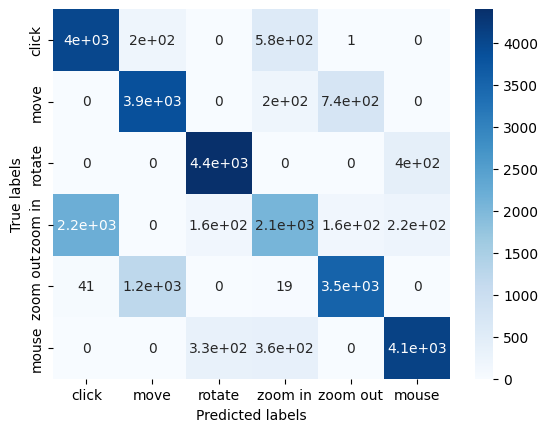

In [13]:
train_label = fold_set[LABEL_COLUMN]
train_features = fold_set.drop(columns=['IDVolunt','IDPergu','IDTrial','FrameID','visible_time','grab_angle','pinch_strength','left/right','palm.dir.x','palm.dir.y','palm.dir.z','palm.normal.x','palm.normal.y','palm.normal.z','palm.orienta.x','palm.orienta.y','palm.orienta.z','palm.orienta.w','palm.stable-pos.x','palm.stable-pos.y','palm.stable-pos.z','palm.velocity.x','palm.velocity.y','palm.velocity.z','palm.width','thumb_extend','index_extend','middle_extended','ring_extended','pinky_extend','arm.rot.x','arm.rot.y','arm.rot.z','arm.rot.w','arm.width','arm.prev.x','arm.prev.y','arm.prev.z','arm.next.x','arm.next.y','arm.next.z','thumb.metacarpal.rot.x','thumb.metacarpal.rot.y','thumb.metacarpal.rot.z','thumb.metacarpal.rot.w','thumb.metacarpal.width','thumb.metacarpal.prev.x','thumb.metacarpal.prev.y','thumb.metacarpal.prev.z','thumb.metacarpal.next.x','thumb.metacarpal.next.y','thumb.metacarpal.next.z','thumb.proximal.rot.x','thumb.proximal.rot.y','thumb.proximal.rot.z','thumb.proximal.rot.w','thumb.proximal.width','thumb.proximal.prev.x','thumb.proximal.prev.y','thumb.proximal.prev.z','thumb.proximal.next.x','thumb.proximal.next.y','thumb.proximal.next.z','thumb.intermediate.rot.x','thumb.intermediate.rot.y','thumb.intermediate.rot.z','thumb.intermediate.rot.w','thumb.intermediate.width','thumb.intermediate.prev.x','thumb.intermediate.prev.y','thumb.intermediate.prev.z','thumb.intermediate.next.x','thumb.intermediate.next.y','thumb.intermediate.next.z','thumb.distal.rot.x','thumb.distal.rot.y','thumb.distal.rot.z','thumb.distal.rot.w','thumb.distal.width','thumb.distal.prev.x','thumb.distal.prev.y','thumb.distal.prev.z','index.metacarpal.rot.x','index.metacarpal.rot.y','index.metacarpal.rot.z','index.metacarpal.rot.w','index.metacarpal.width','index.metacarpal.prev.x','index.metacarpal.prev.y','index.metacarpal.prev.z','index.metacarpal.next.x','index.metacarpal.next.y','index.metacarpal.next.z','index.proximal.rot.x','index.proximal.rot.y','index.proximal.rot.z','index.proximal.rot.w','index.proximal.width','index.proximal.prev.x','index.proximal.prev.y','index.proximal.prev.z','index.proximal.next.x','index.proximal.next.y','index.proximal.next.z','index.intermediate.rot.x','index.intermediate.rot.y','index.intermediate.rot.z','index.intermediate.rot.w','index.intermediate.width','index.intermediate.prev.x','index.intermediate.prev.y','index.intermediate.prev.z','index.intermediate.next.x','index.intermediate.next.y','index.intermediate.next.z','index.distal.rot.x','index.distal.rot.y','index.distal.rot.z','index.distal.rot.w','index.distal.width','index.distal.prev.x','index.distal.prev.y','index.distal.prev.z','middle.metacarpal.rot.x','middle.metacarpal.rot.y','middle.metacarpal.rot.z','middle.metacarpal.rot.w','middle.metacarpal.width','middle.metacarpal.prev.x','middle.metacarpal.prev.y','middle.metacarpal.prev.z','middle.metacarpal.next.x','middle.metacarpal.next.y','middle.metacarpal.next.z','middle.proximal.rot.x','middle.proximal.rot.y','middle.proximal.rot.z','middle.proximal.rot.w','middle.proximal.width','middle.proximal.prev.x','middle.proximal.prev.y','middle.proximal.prev.z','middle.proximal.next.x','middle.proximal.next.y','middle.proximal.next.z','middle.intermediate.rot.x','middle.intermediate.rot.y','middle.intermediate.rot.z','middle.intermediate.rot.w','middle.intermediate.width','middle.intermediate.prev.x','middle.intermediate.prev.y','middle.intermediate.prev.z','middle.intermediate.next.x','middle.intermediate.next.y','middle.intermediate.next.z','middle.distal.rot.x','middle.distal.rot.y','middle.distal.rot.z','middle.distal.rot.w','middle.distal.width','middle.distal.prev.x','middle.distal.prev.y','middle.distal.prev.z','ring.metacarpal.rot.x','ring.metacarpal.rot.y','ring.metacarpal.rot.z','ring.metacarpal.rot.w','ring.metacarpal.width','ring.metacarpal.prev.x','ring.metacarpal.prev.y','ring.metacarpal.prev.z','ring.metacarpal.next.x','ring.metacarpal.next.y','ring.metacarpal.next.z','ring.proximal.rot.x','ring.proximal.rot.y','ring.proximal.rot.z','ring.proximal.rot.w','ring.proximal.width','ring.proximal.prev.x','ring.proximal.prev.y','ring.proximal.prev.z','ring.proximal.next.x','ring.proximal.next.y','ring.proximal.next.z','ring.intermediate.rot.x','ring.intermediate.rot.y','ring.intermediate.rot.z','ring.intermediate.rot.w','ring.intermediate.width','ring.intermediate.prev.x','ring.intermediate.prev.y','ring.intermediate.prev.z','ring.intermediate.next.x','ring.intermediate.next.y','ring.intermediate.next.z','ring.distal.rot.x','ring.distal.rot.y','ring.distal.rot.z','ring.distal.rot.w','ring.distal.width','ring.distal.prev.x','ring.distal.prev.y','ring.distal.prev.z','ring.distal.next.x','ring.distal.next.y','ring.distal.next.z','pinky.metacarpal.rot.x','pinky.metacarpal.rot.y','pinky.metacarpal.rot.z','pinky.metacarpal.rot.w','pinky.metacarpal.width','pinky.metacarpal.prev.x','pinky.metacarpal.prev.y','pinky.metacarpal.prev.z','pinky.metacarpal.next.x','pinky.metacarpal.next.y','pinky.metacarpal.next.z','pinky.proximal.rot.x','pinky.proximal.rot.y','pinky.proximal.rot.z','pinky.proximal.rot.w','pinky.proximal.width','pinky.proximal.prev.x','pinky.proximal.prev.y','pinky.proximal.prev.z','pinky.proximal.next.x','pinky.proximal.next.y','pinky.proximal.next.z','pinky.intermediate.rot.x','pinky.intermediate.rot.y','pinky.intermediate.rot.z','pinky.intermediate.rot.w','pinky.intermediate.width','pinky.intermediate.prev.x','pinky.intermediate.prev.y','pinky.intermediate.prev.z','pinky.intermediate.next.x','pinky.intermediate.next.y','pinky.intermediate.next.z','pinky.distal.rot.x','pinky.distal.rot.y','pinky.distal.rot.z','pinky.distal.rot.w','pinky.distal.width','pinky.distal.prev.x','pinky.distal.prev.y','pinky.distal.prev.z','pinky.distal.next.x','pinky.distal.next.y','pinky.distal.next.z'])

# Instancio um modelo novo
model = tree.DecisionTreeClassifier(random_state=10, criterion='entropy', max_depth=20, min_samples_leaf=8, min_samples_split=2)
# Treino o modelo e guardo a historia num array
history = model.fit(train_features, train_label)

result = model.predict(test_features_reduced)
print(result)
accur = accuracy_score(test_labels_one_column, result)
print(accur)
cm = confusion_matrix(test_labels_one_column, result)

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['click', 'move', 'rotate', 'zoom in', 'zoom out', 'mouse'], yticklabels= ['click', 'move', 'rotate', 'zoom in', 'zoom out', 'mouse'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')